**Mise en situation**
Certains gestionnaires de magasins tentent de comprendre comment augmenter les ventes de leurs magasins. 
Ils ont à leur disposition des données historiques de ventes de différents magasins.

**Question #1 : Préparation des données**

In [1]:
#chargement des données et informations primaires
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#charger l'ensemble de données
ventes = pd.read_csv('stores_sales_forecasting.csv', encoding='latin1')

#la grandeur du data
ventes.shape


(2121, 21)

In [3]:
#comment mes données ressemble?
ventes.head(2)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


In [4]:
#Analyse generale pour comprendre les données que j'ai
ventes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         2121 non-null   int64  
 1   Order ID       2121 non-null   object 
 2   Order Date     2121 non-null   object 
 3   Ship Date      2121 non-null   object 
 4   Ship Mode      2121 non-null   object 
 5   Customer ID    2121 non-null   object 
 6   Customer Name  2121 non-null   object 
 7   Segment        2121 non-null   object 
 8   Country        2121 non-null   object 
 9   City           2121 non-null   object 
 10  State          2121 non-null   object 
 11  Postal Code    2121 non-null   int64  
 12  Region         2121 non-null   object 
 13  Product ID     2121 non-null   object 
 14  Category       2121 non-null   object 
 15  Sub-Category   2121 non-null   object 
 16  Product Name   2121 non-null   object 
 17  Sales          2121 non-null   float64
 18  Quantity

In [5]:
ventes.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,2121.000000,2121.000000,2121.000000,2121.000000,2121.000000,2121.000000
mean,5041.643564,55726.556341,349.834887,3.785007,0.173923,8.699327
std,2885.740258,32261.888225,503.179145,2.251620,0.181547,136.049246
min,1.000000,1040.000000,1.892000,1.000000,0.000000,-1862.312400
25%,2568.000000,22801.000000,47.040000,2.000000,0.000000,-12.849000
50%,5145.000000,60505.000000,182.220000,3.000000,0.200000,7.774800
75%,7534.000000,90032.000000,435.168000,5.000000,0.300000,33.726600
max,9991.000000,99301.000000,4416.174000,14.000000,0.700000,1013.127000


**Observation**: nous avons une propre ensemble de données sans données manquantes
Mais nous avons quelques problemes sur:
1. les Dtype comme order date et ship date sont des Dtype object mais ca devraient etre datetime en principe
2. Certains produits ont des rabais extrêmes, ce qui peut fausser le modèle
3. Distribution des ventes(sales) biaisée et je les considere comme le cible


**Nettoyage des données et ingénierie des fonctionnalités**

In [6]:
#conversion des champs de date
ventes['Order Date'] = pd.to_datetime(ventes['Order Date'])
ventes['Ship Date'] = pd.to_datetime(ventes['Ship Date'])

In [7]:
# Creation des données temporels qui influencent fortement les ventes(agrégation du temps)
ventes['Order Month'] = ventes['Order Date'].dt.month
ventes['Order Weekday'] = ventes['Order Date'].dt.dayofweek
ventes['Is Weekend'] = ventes['Order Weekday'].isin([5, 6]).astype(int)
ventes['Leading Days'] = (ventes['Ship Date'] - ventes['Order Date']).dt.days


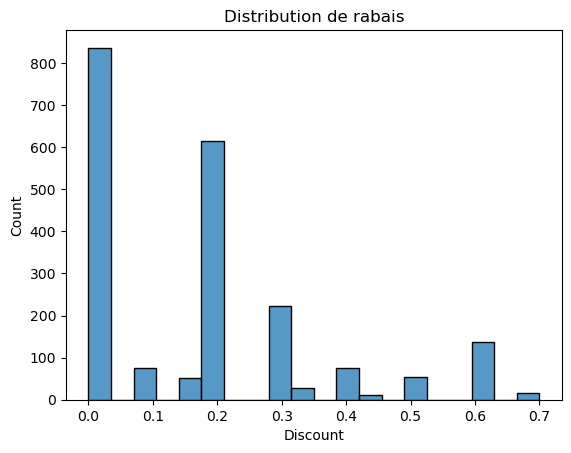

In [8]:
#trier en catégories des rabais
sns.histplot(ventes['Discount'], bins=20)
plt.title('Distribution de rabais')
plt.show()


In [9]:
# pour que les extremes rabais ne fausser pas le modèle, on va les categorize pour reduire l'impact
ventes['Discount Level'] = pd.cut(ventes['Discount'],
                              bins=[-0.01, 0.1, 0.3, 0.6, 1.0],
                              labels=['Low', 'Medium', 'High', 'Extreme'])


Text(0.5, 0, 'Discount')

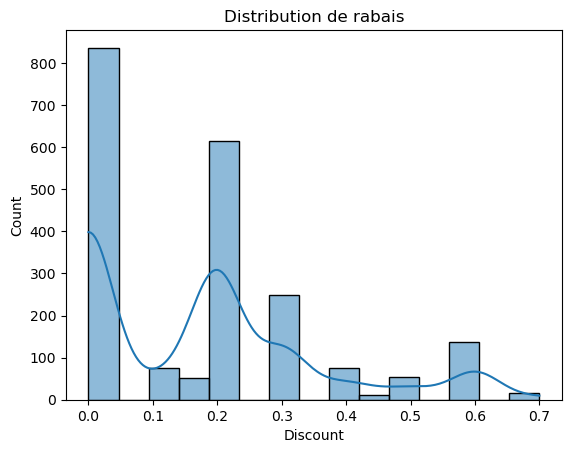

In [10]:
sns.histplot(ventes['Discount'], kde=True)
plt.title('Distribution de rabais')
plt.xlabel('Discount')

Text(0.5, 1.0, 'Raw Sales Distribution')

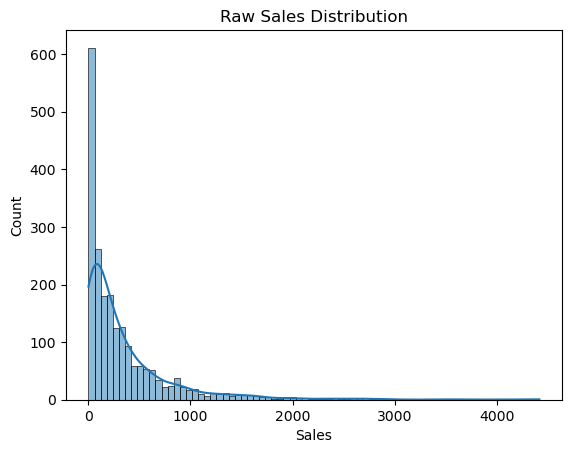

In [11]:
sns.histplot(ventes['Sales'], kde=True)
plt.title('Raw Sales Distribution')


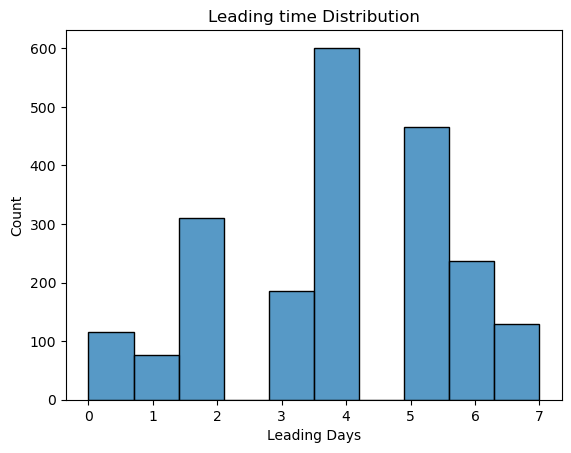

In [12]:
sns.histplot(ventes['Leading Days'], bins=10)
plt.title('Leading time Distribution')
plt.show()

In [13]:
# Normaliser les valeurs de ventes biaisées
#Les ventes ont souvent une distribution biaisée vers la droite, en particulier pour les produits de luxe
#La solution consiste à appliquer une transformation logarithmique pour normaliser les valeurs pour les modèles de régression.
ventes['Log Sales'] = np.log1p(ventes['Sales'])

**Model Preparation**

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Feature selection
features = ['Quantity', 'Discount', 'Profit', 'Order Month', 'Order Weekday',
            'Is Weekend', 'Leading Days']
target = ['Log Sales']

In [15]:

X = ventes[features]
y = ventes[target]

# If 'target' is a list or has only one column, flatten it using ravel():
y = y.values.ravel()  # Converts (n_samples, 1) to (n_samples,)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5)

MAE: 0.4067959446584521
R2: 0.8509233101096447


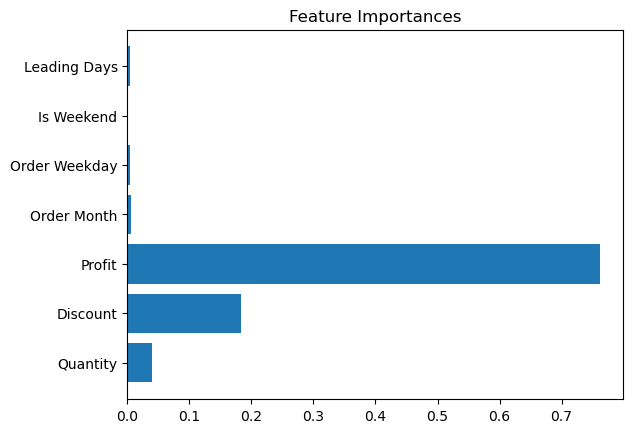

In [16]:
# Evaluation du modele
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

# Feature Importance
importances = model.feature_importances_
plt.barh(features, importances)
plt.title('Feature Importances')
plt.show()

Je prends un example pour vous montre l'ettente de ma modele

In [17]:
my_order = pd.DataFrame({
    'Quantity': [5],
    'Discount': [0.3],
    'Profit': [80],
    'Order Month': [12],
    'Order Weekday': [2],  # Wednesday
    'Is Weekend': [0],
    'Leading Days': [3]
})

log_pred = model.predict(my_order)[0]
sales_prediction = np.expm1(log_pred)

print("\n--- Model Yield Example ---")
print(f"Expected sales value for my_order: ${sales_prediction:.2f}")


--- Model Yield Example ---
Expected sales value for my_order: $817.31


**Question #2 : Insights et interprétation**

pour les parties prenantes, Je les suggere, 
- 10 à 40 % de rabais, selon le produit et la saison.
- Évitez les remises importantes (> 50 %), sauf s'il s'agit de stocks en fin de vie ou de lots.
- Utilisez les remises de manière stratégique sur les produits à rotation lente.
- Adaptez vos promotions en fonction du type de client.

In [18]:
# Discounts et Sales
ventes.groupby('Discount')['Sales'].mean()

Discount
0.00    306.250323
0.10    613.608513
0.15    529.971567
0.20    352.245554
0.30    448.064640
0.32    536.794770
0.40    608.192080
0.45    498.634000
0.50    388.582778
0.60     48.150000
0.70    163.958800
Name: Sales, dtype: float64

<Axes: xlabel='Order Month'>

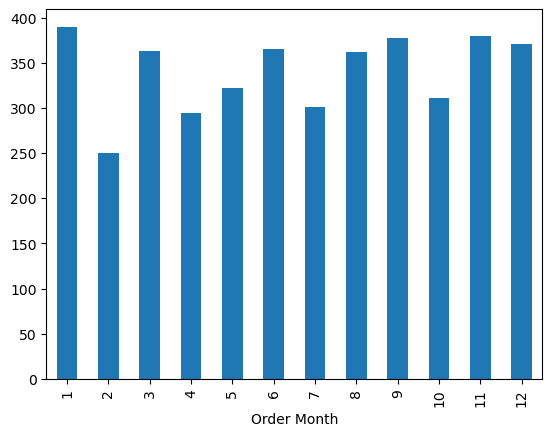

In [19]:
#Saisonnalité
ventes.groupby('Order Month')['Sales'].mean().plot(kind='bar')

In [20]:
#Segment
ventes.groupby('Segment')[['Sales', 'Profit']].mean()


,Sales,Profit
Segment,,
Consumer,351.347091,6.281293
Corporate,354.519792,11.741201
Home Office,336.825131,10.705465


**Question #3 : Solution ML**

J'ai suivi le principe que Gradient Boosting capture les interactions complexes entre les variables et je l'ai choisi parceque il a des excellentes performances sur les données de ventes tabulaires.
    
les avantages:
Haute précision,Interprétabilité
 et Gestion de données mixtes
    
les inconvénients:
Entraînement plus lent sur les grands ensembles de données
nécessite une ingénierie des caractéristiques chargé.

**Question #4 : Dégradation de la performance**

Il y a plusieurs facteurs qui peut implique tout ça comme:
Le comportement des clients ou la stratégie du magasin ont changé.
La distribution des variables d'entrée a évolué (par exemple, moins de promotions).
Nouveaux concurrents, perturbations de la chaîne d'approvisionnement.

pour le resoudre:
je Surveillearais les indicateurs au fil du temps.
et réorganiser le modèle périodiquement.

**Question #5 : Intégration de l'IA générative**

une combinaison de recherche sémantique et de chatbot pourrait être un outil très pratique qui rapporte les performances des ventes et permet au propriétaire du magasin d'interagir en fonction de ses objectifs et de sa situation.
1. La recherche sémantique révèle ce que les clients recherchent réellement, même s'ils ne le trouvent pas.Elle aide les propriétaires à identifier les lacunes dans leur stock ou les tendances qui pourraient leur échapper.

2. En analysant les tendances de recherche, les propriétaires peuvent optimiser les descriptions et les étiquettes de produits en fonction du language des clients.Cela améliore la visibilité et la découvrabilité des produits.

3. Réduction des taux de rebond
Lorsque les clients trouvent ce qu'ils cherchent plus rapidement, ils sont plus susceptibles d'acheter.Cela se traduit par des taux de conversion plus élevés et moins de trafic gaspillé.